In [7]:
!pip install matplotlib
!pip install tabulate

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [8]:
from typing import Iterator
from math import log, sin, pi
from queue import Queue

def lcg(seed: int, m: int=2**32, a: int=1664525, c: int=1013904223) -> Iterator[int]:
    """
    This generator implements the Linear Congruential Generator algorithm
    :param m: the modulus, a positive integer constant
    :param a: the multiplier, a non-negative integer constant < m
    :param c: the increment, a non-negative integer constant < m
    :param seed: the starting state of the LCG. It is used to initialize the pseudo-random number sequence
    :return: a non-negative integer in [0, m-1] representing the i-th state of the generator
    """
    x = seed
    while True:
        x = (a * x + c) % m
        yield x/m

def xorshift_64(seed: int) -> Iterator[int]:
    """
    This generator implements the XORShift algorithm.
    :param seed: the initial state of the generator. Should be a non-zero integer.
    :return: pseudo-random integers generated by the XORShift algorithm.
    """
    x = seed if seed != 0 else 1
    while True:
        x ^= (x << 13) & 0xFFFFFFFFFFFFFFFF
        x ^= (x >> 7) & 0xFFFFFFFFFFFFFFFF
        x ^= (x << 17) & 0xFFFFFFFFFFFFFFFF
        x &= 0xFFFFFFFFFFFFFFFF
        yield x/0xFFFFFFFFFFFFFFFF


def rotl(x: int, k: int) -> int:
    return ((x << k) | (x >> (64 - k))) & 0xFFFFFFFFFFFFFFFF

def xoshiro_64(seed: list[int]) -> Iterator[int]:
    """
    xoshiro256++ generator
    :param seed: list of 4 uint64 integers, the internal state (cant be all 0)
    :return: pseudo-random 64-bit integers
    """
    s = seed.copy()
    if len(s) != 4 or all(x == 0 for x in s):
        raise ValueError("Seed must be a list of 4 non-zero uint64 integers")

    while True:
        result = (rotl(s[0] + s[3], 23) + s[0]) & 0xFFFFFFFFFFFFFFFF
        t = (s[1] << 17) & 0xFFFFFFFFFFFFFFFF

        s[2] ^= s[0]
        s[3] ^= s[1]
        s[1] ^= s[2]
        s[0] ^= s[3]

        s[2] ^= t
        s[3] = rotl(s[3], 45)

        yield result/0xFFFFFFFFFFFFFFFF
        
def Poisson_adelgazamiento_mejorado(T, generator):
    interv = [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48]
    lamda = [12.5, 27.5, 35, 35, 27.5, 12.5, 12.5, 27.5, 35, 35, 27.5, 12.5]
    j = 0 #recorre subintervalos.
    t =-log (1 - next(generator) ) / lamda[j]
    NT = 0
    Eventos = []
    while t <= T:
        if t <= interv[j]:
            V = next(generator)
            if V < 20 + 15*sin((t-6)*2*pi/24) / lamda[j]:
                Eventos.append(t)
                t +=-log(1- next(generator)) / lamda[j]
        else: #t > interv[j]
            t = interv[j] + (t- interv[j]) * lamda[j] / lamda[j + 1]
            j += 1
    return Eventos

class Cliente:
    def __init__(self, tiempo_llegada: float):
        self.tiempo_llegada = tiempo_llegada
        self.tiempo_espera = 0.0
        self.tiempo_en_sistema = 0.0
    

def simulacion(generator):
    T = 48
    Eventos = Poisson_adelgazamiento_mejorado(T, generator)
    j = 0
    tiempo_actual = 0
    cola = Queue()
    datos_clientes = []
    datos_cola = {}
    tiempos_servicio = []
    while True:
        if cola.empty():
            if j < len(Eventos):
                tiempo_actual = Eventos[j]
                cliente = Cliente(tiempo_actual)
                cola.put(cliente)
                j += 1
                datos_cola[tiempo_actual] = cola.qsize()
            else:
                break
        else:
            cliente_atendido = cola.get()
            cliente_atendido.tiempo_espera = tiempo_actual - cliente_atendido.tiempo_llegada
            
            tiempo_servicio = -log(1 - next(generator)) / 35
            tiempo_actual += tiempo_servicio
            while j < len(Eventos) and Eventos[j] < tiempo_actual:
                cliente = Cliente(Eventos[j])
                cola.put(cliente)
                datos_cola[Eventos[j]] = cola.qsize()
                j += 1
            if tiempo_actual > T:
                for cliente in list(cola.queue):
                    cliente.tiempo_espera += T - cliente.tiempo_llegada
                    cliente.tiempo_en_sistema = cliente.tiempo_espera
                    datos_clientes.append(cliente)
                break
            
            
            tiempos_servicio.append(tiempo_servicio)
            cliente_atendido.tiempo_en_sistema = cliente_atendido.tiempo_espera + tiempo_servicio
            
            datos_clientes.append(cliente_atendido)
            datos_cola[tiempo_actual] = cola.qsize()
            
            
    return datos_clientes, datos_cola, Eventos, tiempos_servicio



In [ ]:
resultados = {}


# Inicializar listas para cada generador
resultados["LCG"] = []
resultados["XORShift"] = []
resultados["Xoshiro"] = []
N = 300
for i in range(N):
    gen_lcg = lcg(seed=i)
    gen_xor = xorshift_64(seed=i)
    gen_xoshiro = xoshiro_64(seed=[i, i+N, i+N*2, i+N*3])

    datos_clientes_lcg, datos_cola_lcg, eventos_lcg, tiempos_servicio_lcg = simulacion(gen_lcg)
    datos_clientes_xor, datos_cola_xor, eventos_xor, tiempos_servicio_xor = simulacion(gen_xor)
    datos_clientes_xoshiro, datos_cola_xoshiro, eventos_xoshiro, tiempos_servicio_xoshiro = simulacion(gen_xoshiro)

    resultados["LCG"].append({
        "clientes": datos_clientes_lcg,
        "cola": datos_cola_lcg,
        "eventos": eventos_lcg,
        "servicios": tiempos_servicio_lcg
    })
    resultados["XORShift"].append({
        "clientes": datos_clientes_xor,
        "cola": datos_cola_xor,
        "eventos": eventos_xor,
        "servicios": tiempos_servicio_xor
    })
    resultados["Xoshiro"].append({
        "clientes": datos_clientes_xoshiro,
        "cola": datos_cola_xoshiro,
        "eventos": eventos_xoshiro,
        "servicios": tiempos_servicio_xoshiro
    })


In [10]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np


def comparar_generadores(resultados):
    nombres = list(resultados.keys())

    # Mostrar la distribución del tiempo de espera promedio por simulación para cada generador
    fig, axs = plt.subplots(1, len(nombres), figsize=(18, 4))
    for i, nombre in enumerate(nombres):
        # Obtener los promedios de espera de cada simulación
        promedios_espera = [run["clientes"] for run in resultados[nombre]]
        # Calcular el tiempo de espera promedio por simulación
        espera_media_sim = [
            np.mean([c.tiempo_espera for c in clientes]) for clientes in promedios_espera
        ]
        axs[i].hist(espera_media_sim, bins=30, color='skyblue', edgecolor='black')
        axs[i].set_title(f"{nombre} - Distribución espera promedio")
        axs[i].set_xlabel("Espera promedio (h)")
        axs[i].set_ylabel("Frecuencia")
        axs[i].grid(True)
    plt.suptitle("Distribución del tiempo de espera promedio por simulación (300 simulaciones)")
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1, len(nombres), figsize=(18, 4))
    for i, nombre in enumerate(nombres):
        # Inicializar ocupación promedio por hora (0-47)
        ocupacion_promedio = np.zeros(48)
        runs = resultados[nombre]
        for run in runs:
            clientes = run["clientes"]
            # Para cada cliente, sumar el tiempo de servicio en cada hora correspondiente
            for c in clientes:
                inicio = c.tiempo_llegada + c.tiempo_espera
                fin = inicio + (c.tiempo_en_sistema - c.tiempo_espera)
                hora_inicio = int(inicio)
                hora_fin = min(48, int(fin) + 1)
                for h in range(hora_inicio, hora_fin):
                    t_ini = max(inicio, h)
                    t_fin = min(fin, h + 1)
                    ocupacion_promedio[h] += (t_fin - t_ini)
        ocupacion_promedio /= len(runs)  # Promedio sobre las simulaciones
        axs[i].bar(range(48), ocupacion_promedio)
        axs[i].set_title(f"{nombre} - Ocupación")
        axs[i].set_xlabel("Hora")
        axs[i].set_xlim(-1, 48)
        axs[i].set_ylabel("Horas ocupado")
        axs[i].set_ylim(0, 1)
    plt.suptitle("Ocupación por hora del servidor")
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1, len(nombres), figsize=(18, 4))
    for i, nombre in enumerate(nombres):
        runs = resultados[nombre]
        intervalos_6_minutos = range(48 * 10)  # 0 a 479 (6 minutos = 0.1 horas)
        intervalos = {h: [] for h in intervalos_6_minutos}
        for run in runs:
            datos_cola = run["cola"]
            for t, tam in datos_cola.items():
                m = int(t * 10)  # Convertir tiempo a intervalos de 6 minutos
                if m in intervalos:
                    intervalos[m].append(tam)
        medias = [np.mean(intervalos[h]) if intervalos[h] else 0 for h in intervalos_6_minutos]
        variaciones = [np.var(intervalos[h]) if intervalos[h] else 0 for h in intervalos_6_minutos]

        x_vals = np.array(intervalos_6_minutos) / 10 # Convertir de intervalos de 6 minutos a horas

        axs[i].plot(x_vals, medias, label="Media")
        axs[i].fill_between(
            x_vals,
            [m - np.sqrt(v) for m, v in zip(medias, variaciones)],
            [m + np.sqrt(v) for m, v in zip(medias, variaciones)],
            color='gray', alpha=0.3, label="±1 Desv."
        )
        axs[i].set_title(f"{nombre} - Tamaño de la cola")
        axs[i].set_xlabel("Hora")
        axs[i].xaxis.set_major_locator(MultipleLocator(4))
        axs[i].set_xlim(0, 48)
        axs[i].set_ylabel("Clientes en cola")
        axs[i].grid(True)
        axs[i].set_ylim(0, 50)
        axs[i].yaxis.set_major_locator(MultipleLocator(10))
        axs[i].legend()
    plt.suptitle("Evolución del tamaño de la cola")
    plt.tight_layout()
    plt.show()


In [11]:

from tabulate import tabulate

    
def tabla_resumen(resultados):
    resumen_ic = []
    resumen_uso = []
    resumen_cola = []
    N = len(resultados[list(resultados.keys())[0]])  # Número de simulaciones por generador
    for nombre, runs in resultados.items():
        todas_las_esperas = []
        todas_las_ocupaciones = []
        todas_las_colas = []
        for run in runs:
            clientes = run["clientes"]
            espera_prom = sum(c.tiempo_espera for c in clientes) / len(clientes)
            todas_las_esperas.append(espera_prom)
            uso_prom = sum(c.tiempo_en_sistema - c.tiempo_espera for c in clientes) / 48  # 48 horas de simulación
            todas_las_ocupaciones.append(uso_prom)
            # Tamaño promedio de la cola en la simulación
            datos_cola = run["cola"]
            if len(datos_cola) > 0:
                tam_cola_prom = np.mean(list(datos_cola.values()))
            else:
                tam_cola_prom = 0
            todas_las_colas.append(tam_cola_prom)
        # Tabla de intervalos de confianza para el tiempo de espera
        esperas = np.array(todas_las_esperas)
        media_espera = np.mean(esperas)
        S_espera = np.std(esperas, ddof=1)
        margen = 1.96 * S_espera / np.sqrt(N)
        ic_inferior = media_espera - margen
        ic_superior = media_espera + margen
        resumen_ic.append([
            nombre,
            round(media_espera, 4),
            round(S_espera, 4),
            f"[{ic_inferior:.4f}, {ic_superior:.4f}]"
        ])
        # Tabla de intervalos de confianza para uso promedio
        usos_promedios = np.array(todas_las_ocupaciones)
        media_ocupacion = np.mean(usos_promedios)
        S_ocupacion = np.std(usos_promedios, ddof=1)
        margen_ocup = 1.96 * S_ocupacion / np.sqrt(N)
        ic_inf_ocup = media_ocupacion - margen_ocup
        ic_sup_ocup = media_ocupacion + margen_ocup
        resumen_uso.append([
            nombre,
            round(media_ocupacion, 4),
            round(S_ocupacion, 4),
            f"[{ic_inf_ocup:.4f}, {ic_sup_ocup:.4f}]"
        ])
        # Tabla de intervalos de confianza para tamaño de la cola
        colas = np.array(todas_las_colas)
        media_cola = np.mean(colas)
        S_cola = np.std(colas, ddof=1)
        margen_cola = 1.96 * S_cola / np.sqrt(N)
        ic_inf_cola = media_cola - margen_cola
        ic_sup_cola = media_cola + margen_cola
        resumen_cola.append([
            nombre,
            round(media_cola, 4),
            round(S_cola, 4),
            f"[{ic_inf_cola:.4f}, {ic_sup_cola:.4f}]"
        ])

    print("Tabla de intervalos de confianza para el tiempo de espera promedio:")
    print(tabulate(
        resumen_ic,
        headers=["Generador", "Media espera", "S", "IC 95%"],
        tablefmt="fancy_grid"
    ))
    print("\nTabla de intervalos de confianza para el uso promedio del servidor:")
    print(tabulate(
        resumen_uso,
        headers=["Generador", "Uso promedio", "S", "IC 95%"],
        tablefmt="fancy_grid"
    ))
    print("\nTabla de intervalos de confianza para el tamaño promedio de la cola:")
    print(tabulate(
        resumen_cola,
        headers=["Generador", "Tamaño cola", "S", "IC 95%"],
        tablefmt="fancy_grid"
    ))



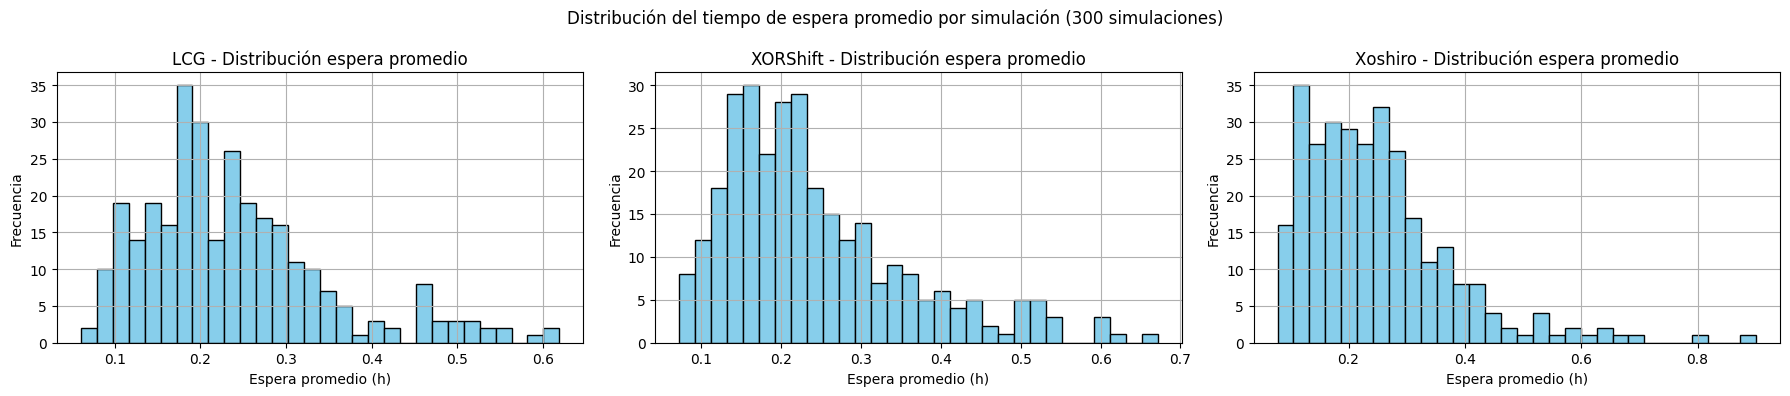

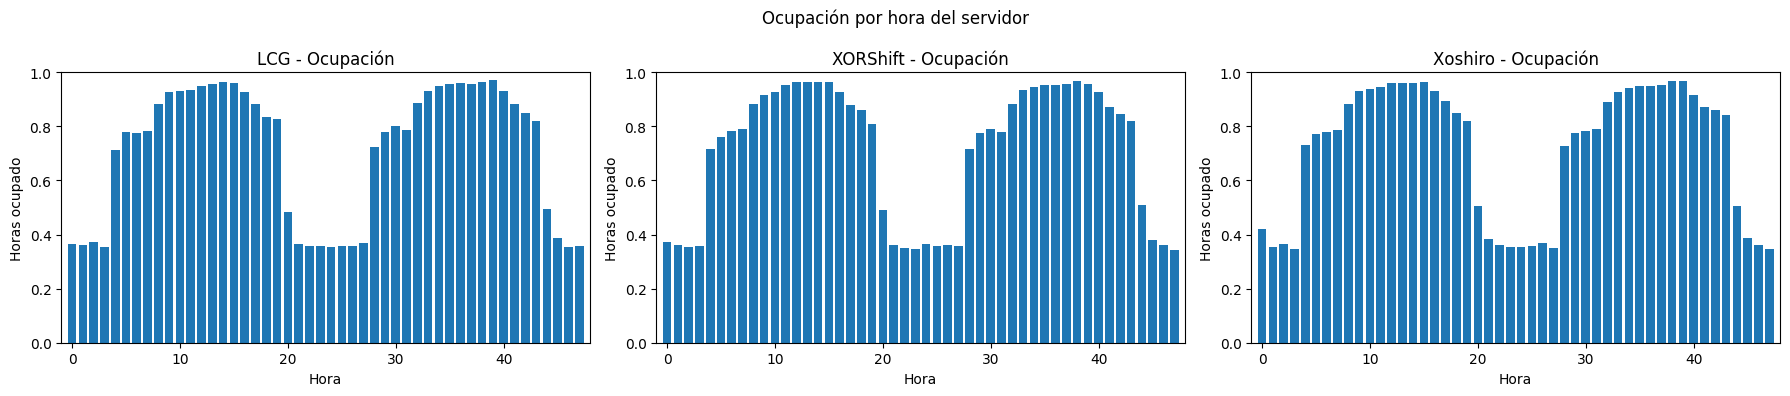

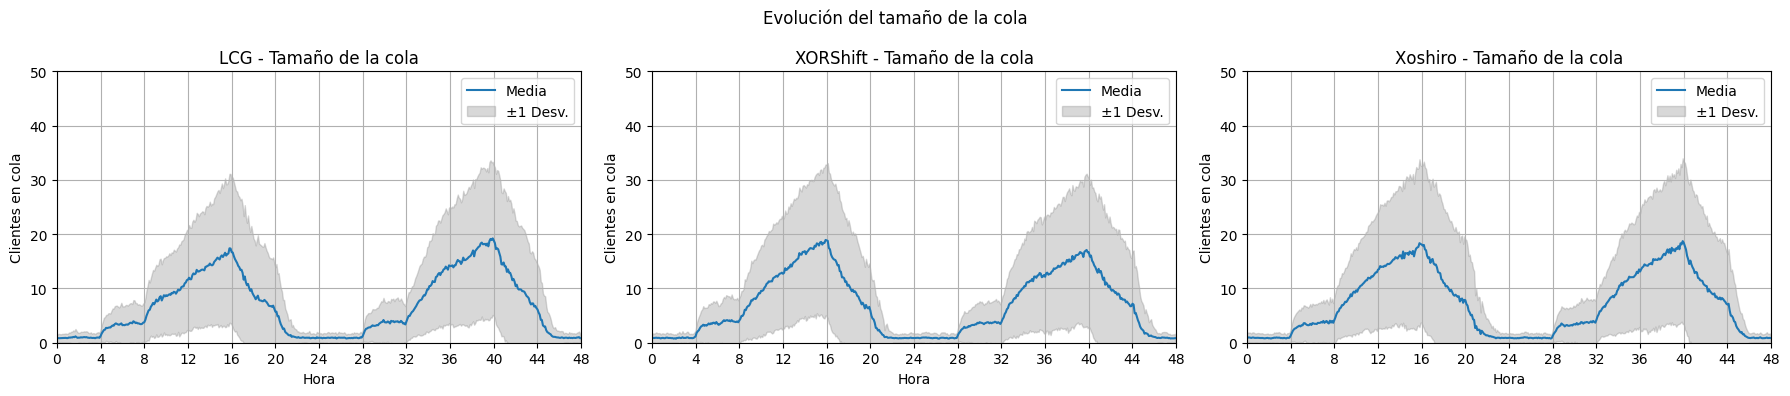

Tabla de intervalos de confianza para el tiempo de espera promedio:
╒═════════════╤════════════════╤════════╤══════════════════╕
│ Generador   │   Media espera │      S │ IC 95%           │
╞═════════════╪════════════════╪════════╪══════════════════╡
│ LCG         │         0.2388 │ 0.109  │ [0.2264, 0.2511] │
├─────────────┼────────────────┼────────┼──────────────────┤
│ XORShift    │         0.2423 │ 0.1169 │ [0.2291, 0.2555] │
├─────────────┼────────────────┼────────┼──────────────────┤
│ Xoshiro     │         0.2487 │ 0.127  │ [0.2344, 0.2631] │
╘═════════════╧════════════════╧════════╧══════════════════╛

Tabla de intervalos de confianza para el uso promedio del servidor:
╒═════════════╤════════════════╤════════╤══════════════════╕
│ Generador   │   Uso promedio │      S │ IC 95%           │
╞═════════════╪════════════════╪════════╪══════════════════╡
│ LCG         │         0.7132 │ 0.0291 │ [0.7099, 0.7165] │
├─────────────┼────────────────┼────────┼──────────────────┤
│ XORShif

In [12]:
comparar_generadores(resultados)
tabla_resumen(resultados)